## Import modules

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.engine.topology import Layer
from keras import backend as K
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from utils import LRN2D
import utils
import glob
import matplotlib.pyplot as plt
%matplotlib inline
original_path = os.getcwd()

Using TensorFlow backend.


## Predefined model for face recognition

In [2]:
myInput = Input(shape=(96, 96, 3))

x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)
x = Lambda(LRN2D, name='lrn_1')(x)
x = Conv2D(64, (1, 1), name='conv2')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = Conv2D(192, (3, 3), name='conv3')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
x = Activation('relu')(x)
x = Lambda(LRN2D, name='lrn_2')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)

# Inception3a
inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
inception_3a_pool = Activation('relu')(inception_3a_pool)
inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

# Inception3b
inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

inception_3b_pool = Lambda(lambda x: x**2, name='power2_3b')(inception_3a)
inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3b_pool)
inception_3b_pool = Lambda(lambda x: x*9, name='mult9_3b')(inception_3b_pool)
inception_3b_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_3b')(inception_3b_pool)
inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
inception_3b_pool = Activation('relu')(inception_3b_pool)
inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

# Inception3c
inception_3c_3x3 = utils.conv2d_bn(inception_3b,
                                   layer='inception_3c_3x3',
                                   cv1_out=128,
                                   cv1_filter=(1, 1),
                                   cv2_out=256,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(2, 2),
                                   padding=(1, 1))

inception_3c_5x5 = utils.conv2d_bn(inception_3b,
                                   layer='inception_3c_5x5',
                                   cv1_out=32,
                                   cv1_filter=(1, 1),
                                   cv2_out=64,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(2, 2),
                                   padding=(2, 2))

inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

#inception 4a
inception_4a_3x3 = utils.conv2d_bn(inception_3c,
                                   layer='inception_4a_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=192,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))
inception_4a_5x5 = utils.conv2d_bn(inception_3c,
                                   layer='inception_4a_5x5',
                                   cv1_out=32,
                                   cv1_filter=(1, 1),
                                   cv2_out=64,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(1, 1),
                                   padding=(2, 2))

inception_4a_pool = Lambda(lambda x: x**2, name='power2_4a')(inception_3c)
inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4a_pool)
inception_4a_pool = Lambda(lambda x: x*9, name='mult9_4a')(inception_4a_pool)
inception_4a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_4a')(inception_4a_pool)
inception_4a_pool = utils.conv2d_bn(inception_4a_pool,
                                   layer='inception_4a_pool',
                                   cv1_out=128,
                                   cv1_filter=(1, 1),
                                   padding=(2, 2))
inception_4a_1x1 = utils.conv2d_bn(inception_3c,
                                   layer='inception_4a_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))
inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

#inception4e
inception_4e_3x3 = utils.conv2d_bn(inception_4a,
                                   layer='inception_4e_3x3',
                                   cv1_out=160,
                                   cv1_filter=(1, 1),
                                   cv2_out=256,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(2, 2),
                                   padding=(1, 1))
inception_4e_5x5 = utils.conv2d_bn(inception_4a,
                                   layer='inception_4e_5x5',
                                   cv1_out=64,
                                   cv1_filter=(1, 1),
                                   cv2_out=128,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(2, 2),
                                   padding=(2, 2))
inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

#inception5a
inception_5a_3x3 = utils.conv2d_bn(inception_4e,
                                   layer='inception_5a_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=384,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))

inception_5a_pool = Lambda(lambda x: x**2, name='power2_5a')(inception_4e)
inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_5a_pool)
inception_5a_pool = Lambda(lambda x: x*9, name='mult9_5a')(inception_5a_pool)
inception_5a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_5a')(inception_5a_pool)
inception_5a_pool = utils.conv2d_bn(inception_5a_pool,
                                   layer='inception_5a_pool',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   padding=(1, 1))
inception_5a_1x1 = utils.conv2d_bn(inception_4e,
                                   layer='inception_5a_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))

inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

#inception_5b
inception_5b_3x3 = utils.conv2d_bn(inception_5a,
                                   layer='inception_5b_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=384,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))
inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
inception_5b_pool = utils.conv2d_bn(inception_5b_pool,
                                   layer='inception_5b_pool',
                                   cv1_out=96,
                                   cv1_filter=(1, 1))
inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

inception_5b_1x1 = utils.conv2d_bn(inception_5a,
                                   layer='inception_5b_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))
inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
reshape_layer = Flatten()(av_pool)
dense_layer = Dense(128, name='dense_layer')(reshape_layer)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)


# Final Model
model = Model(inputs=[myInput], outputs=norm_layer)

## Load pre-trained weights

In [3]:
weights = utils.weights
weights_dict = utils.load_weights()

# Set layer weights of the model
for name in weights:
    if model.get_layer(name) != None:
        model.get_layer(name).set_weights(weights_dict[name])
    elif model.get_layer(name) != None:
        model.get_layer(name).set_weights(weights_dict[name])

## `detect_face` to detect frontal faces in *gray* and crop in *RGB*

In [4]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
img_row = 96
img_col = 96

In [5]:
def detect_face(img,fc=face_cascade):
    img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = fc.detectMultiScale(img_grey) # higher accuracy for faces with black glasses
    height,width = img_grey.shape
    face_box = [0,0,0,0]
    for (x, y, w, h) in faces:
#         print((x, y, w, h)) # count number of all bounding boxes 
        if w > face_box[2]:
            face_box = [x,y,w,h] # IGNOTE ALL OTHER FALSY FACE BOXES
    x,y,w,h = face_box
    cropped = img_color[y:y+h,x:x+w].copy() # crop without a bounding box
    
    img_color = cv2.rectangle(img_color, (x, y), (x+w, y+h), (255,0,0), 4)    

    return img_color,cropped

In [6]:
test_img = cv2.imread('test/sean.jpg')
test_img.shape

(960, 540, 3)

In [7]:
test_img,cropped = detect_face(test_img)

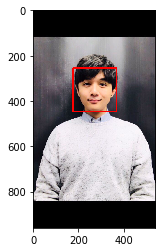

In [8]:
plt.imshow(test_img)

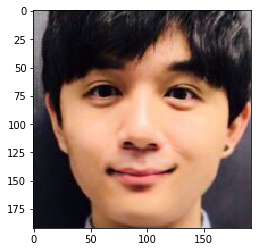

In [9]:
plt.imshow(cropped)

## `embed_image` to embed images

In [10]:
def embed_image(full_img, model):
    _,cropped = detect_face(full_img)
    img = cv2.resize(cropped, (img_row,img_col)).astype('float32')
    img /= 255.0
    img = np.expand_dims(img,axis=0)
    embedding = model.predict_on_batch(img)
    return embedding

## `database_face_embedding` for Database embedding based on the cropped frontal faces

In [11]:
def database_face_embedding():
    database_embeddings = {}
    os.chdir(os.path.join(os.getcwd(),'image_database'))
    for img_file in os.listdir():
        name = img_file.split('.')[0]
        image_file = cv2.imread(img_file)
          
        database_embeddings[name] = embed_image(image_file, model)
    os.chdir(original_path)
    return database_embeddings

In [12]:
database_embeddings = database_face_embedding()
print('current database contains {} images'.format(len(database_embeddings)))

current database contains 2 images


In [13]:
test_img_2 = cv2.imread('test/sean_2.jpg')

In [14]:
def detect_face_with_label(img,name,fc=face_cascade):
    img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = fc.detectMultiScale(img_grey) # higher accuracy for faces with black glasses
    height,width = img_grey.shape
    face_box = [0,0,0,0]
    for (x, y, w, h) in faces:
        if w > face_box[2]:
            face_box = [x,y,w,h] # IGNOTE ALL OTHER FALSY FACE BOXES
    x,y,w,h = face_box
    text = '{}'.format(name)
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN,2,5)[0]
    text_offset_x = x-3
    text_offset_y = y
    box_coords = ((text_offset_x, text_offset_y+10), (text_offset_x+text_width,text_offset_y-text_height-10))
    img_color = cv2.rectangle(img_color, (x, y), (x+w, y+h), (255,0,0), 4)
    img_color = cv2.rectangle(img_color, box_coords[0], box_coords[1], (255,0,0), cv2.FILLED)    
    img_color = cv2.putText(img_color,text,(x,y),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),3)

    return img_color

## `face_recog` to recognize face from an image!

In [15]:
def face_recog(new_face_image, database_embeddings, model):
    new_embedding = embed_image(new_face_image, model) # embed new image
    name = ''
    min_dist = 100

    for (registered_name, registered_embedding) in database_embeddings.items():
        euc_dist = np.linalg.norm(new_embedding-registered_embedding)
        print('Euclidean distance from {} is {}'.format(registered_name, euc_dist))
      
        if euc_dist < min_dist:
            min_dist = euc_dist
            name = registered_name
    
    if min_dist < 0.70:
        test_img = detect_face_with_label(new_face_image,name)
        plt.figure(figsize=(10,10))
        plt.imshow(test_img)
        return str(name)
    else:
        print('Not registered!')       

Euclidean distance from sean is 0.6802952885627747
Euclidean distance from jason is 0.8586575984954834


'sean'

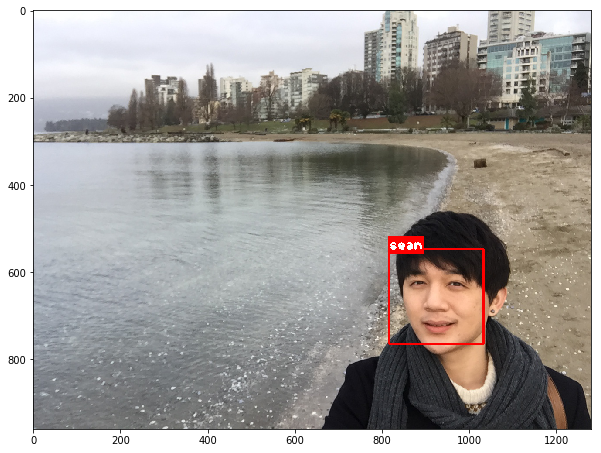

In [16]:
face_recog(test_img_2,database_embeddings,model)